In [1]:
import pandas as pd
import numpy as np
import os
import trajectory_planning_helpers as tph
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from f1tenth_benchmarks.utils.MapData import MapData
from f1tenth_benchmarks.data_tools.plotting_utils import *


if os.getcwd().split('/')[-1] == 'benchmark_results':
    os.chdir('..')
    os.chdir('..')
    print(f'Changed directory to root of repo: {os.getcwd()}')

save_path = 'Data/BenchmarkArticle/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

Changed directory to root of repo: /home/benjy/Documents/RacingRepos/f1tenth_sim


/tmp/ipykernel_520370/3978380613.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


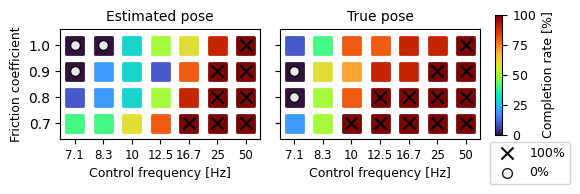

In [2]:

summary_df = pd.read_csv("Logs/Summary.csv")

summary_df = summary_df[summary_df.Vehicle.isin(["FullStackPP300", "GlobalPlanPP"])]
test_ids = summary_df["TestID"].str.split("_", expand=True)
summary_df["mu"] = test_ids[0].str[2:].astype(float) / 100
timestep_series = test_ids[1].str[5:]
timestep_series.dropna(inplace=True)
summary_df["simulator_timestep"] = timestep_series.astype(int)
summary_df["frequency"] = 100 / summary_df["simulator_timestep"] 
summary_df["CompletionRate"] *= 100
summary_df["AvgProgress"] *= 100

selected_timesteps = [2, 4, 6, 8, 10, 12, 14]
summary_df = summary_df[summary_df["simulator_timestep"].isin(selected_timesteps)]

friction_vals = [0.7, 0.8, 0.9, 1]
summary_df = summary_df[summary_df["mu"].isin(friction_vals)]

map_name = "aut"
size = 150
fig, axs = plt.subplots(1, 2, figsize=(5, 2.), sharex=True, sharey=True)

full_stack = summary_df[(summary_df["MapName"] == map_name) & (summary_df["Vehicle"] == "FullStackPP300")]
a0 = axs[0].scatter(full_stack["simulator_timestep"], full_stack["mu"], s=size, c=full_stack["CompletionRate"], marker='s', linewidth=2, cmap='turbo', vmin=0, vmax=100)
axs[0].set_title("Estimated pose", size=10)

complete_df = full_stack.loc[full_stack.CompletionRate >= 99]
axs[0].scatter(complete_df["simulator_timestep"], complete_df["mu"], s=size/2, c='k', marker='x')
complete_df = full_stack.loc[full_stack.CompletionRate <= 1]
axs[0].scatter(complete_df["simulator_timestep"], complete_df["mu"], s=size/3, edgecolors='k', marker='o', alpha=0.9, facecolor='w') 

planning = summary_df[(summary_df["MapName"] == map_name) & (summary_df["Vehicle"] == "GlobalPlanPP")]
a1 = axs[1].scatter(planning["simulator_timestep"], planning["mu"], s=size, c=planning["CompletionRate"], marker='s', linewidth=2, cmap='turbo', vmin=0, vmax=100)

complete_df = planning.loc[planning.CompletionRate >= 99]
axs[1].scatter(complete_df["simulator_timestep"], complete_df["mu"], s=size/2, c='k', marker='x', label="100%")
complete_df = planning.loc[planning.CompletionRate <= 1]
axs[1].scatter(complete_df["simulator_timestep"], complete_df["mu"], s=size/3, edgecolors='k', marker='o', alpha=0.9, facecolor='w', label="0%")   

ax = plt.gca()
cax = fig.add_axes([ax.get_position().x1+0.1, ax.get_position().y0+0.19, 0.015, ax.get_position().height*0.78])
cbar = plt.colorbar(a1, cax=cax)
cbar.set_label("Completion rate [%]", size=9)
cbar.ax.tick_params(labelsize=9)

axs[1].set_title("True pose", size=10)

axs[0].set_ylabel("Friction coefficient", size=9)
axs[0].set_ylim(0.64, 1.06)
axs[0].yaxis.set_major_locator(plt.MaxNLocator(5))


for ax in axs:
    ax.set_xlabel("Control frequency [Hz]", size=9)
    
    ax.set_xticks([2, 4, 6, 8, 10, 12, 14])
    ax.set_xticklabels([50, 25, 16.7, 12.5, 10, 8.3, 7.1], fontsize=8.5)

    ax.set_xlim(15, 1)

plt.tight_layout()
axs[1].legend(loc='center', bbox_to_anchor=(1.25, -0.22), fontsize=9)

plt.savefig(save_path + "FrequencyFrictionCompletionRate.svg", bbox_inches='tight')
plt.savefig(save_path + "FrequencyFrictionCompletionRate.pdf", bbox_inches='tight')


i: 0 - timestep: mu70_steps2
i: 1 - timestep: mu100_steps2


/tmp/ipykernel_520370/3041053098.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


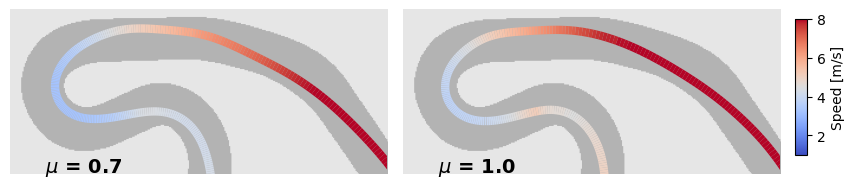

In [3]:
planner = "FullStackPP"
test_ids = ["mu70_steps2", "mu100_steps2"]

plot_map = "gbr"
map_data = MapData(plot_map)

lap_n = 0

lap_dfs = []
for i, test_id in enumerate(test_ids):
    data = np.load(f"Logs/{planner}/RawData_{test_id}/SimLog_{plot_map}_{lap_n}.npy")[1:, :] #remove first repeated entry
    df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
    df["test_id"] = test_id
    lap_dfs.append(df)

lap_df = pd.concat(lap_dfs)
lap_df.dropna(inplace=True)


fig, axs = plt.subplots(1, len(test_ids), figsize=(8, 2.5), sharex=True, sharey=True)
for i in range(len(test_ids)):
    print(f"i: {i} - timestep: {test_ids[i]}")
    plt.sca(axs[i])
    map_data.plot_map_img()

    df = lap_df[lap_df['test_id'] == test_ids[i]]

    xs, ys = map_data.xy2rc(df.x, df.y)
    pts = np.array([xs, ys]).T.reshape(-1, 1, 2)
    segments = np.concatenate([pts[:-1], pts[1:]], axis=1)
    norm = plt.Normalize(1, 8)
    lc = LineCollection(segments, cmap='coolwarm', norm=norm)
    lc.set_array(df.speed.values)
    lc.set_linewidth(6)
    line = plt.gca().add_collection(lc)
    
    plt.axis('off')
    axs[i].set_aspect('equal')
    plt.xlim(840, 1160)
    plt.ylim(720, 860)

axs[0].text(870, 722, "$\mu$ = 0.7", fontsize=14, fontdict={'weight': 'bold'})
axs[1].text(870, 722, "$\mu$ = 1.0", fontsize=14, fontdict={'weight': 'bold'})

ax = plt.gca()
cax = fig.add_axes([ax.get_position().x1+0.1, ax.get_position().y0, 0.015, ax.get_position().height*1.1])
plt.colorbar(line, cax=cax, label="Speed [m/s]", ticks=[2, 4, 6, 8])
plt.tight_layout()

plt.savefig(f"{save_path}trajectory_mu_comparison_{map_name}.pdf", bbox_inches='tight')